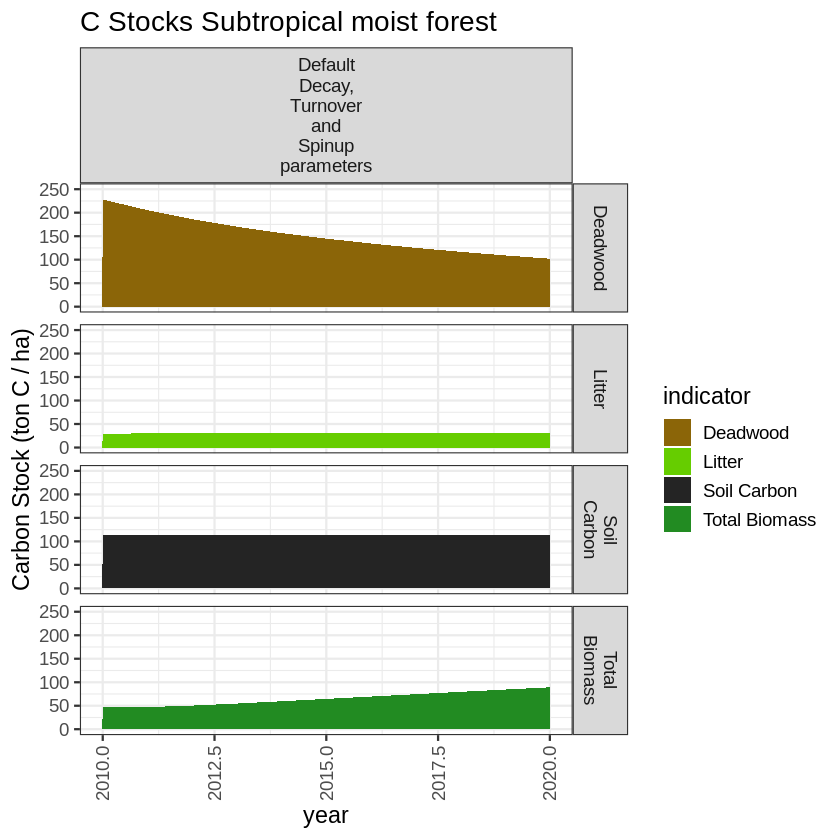

In [ ]:
plots[[1]]


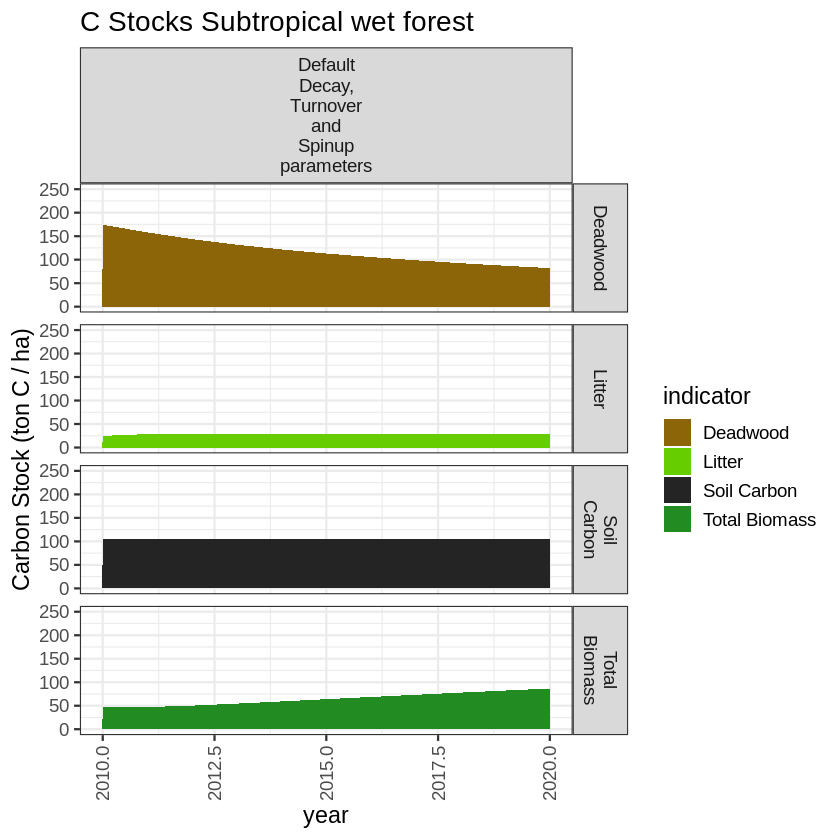

In [ ]:
plots[[2]]

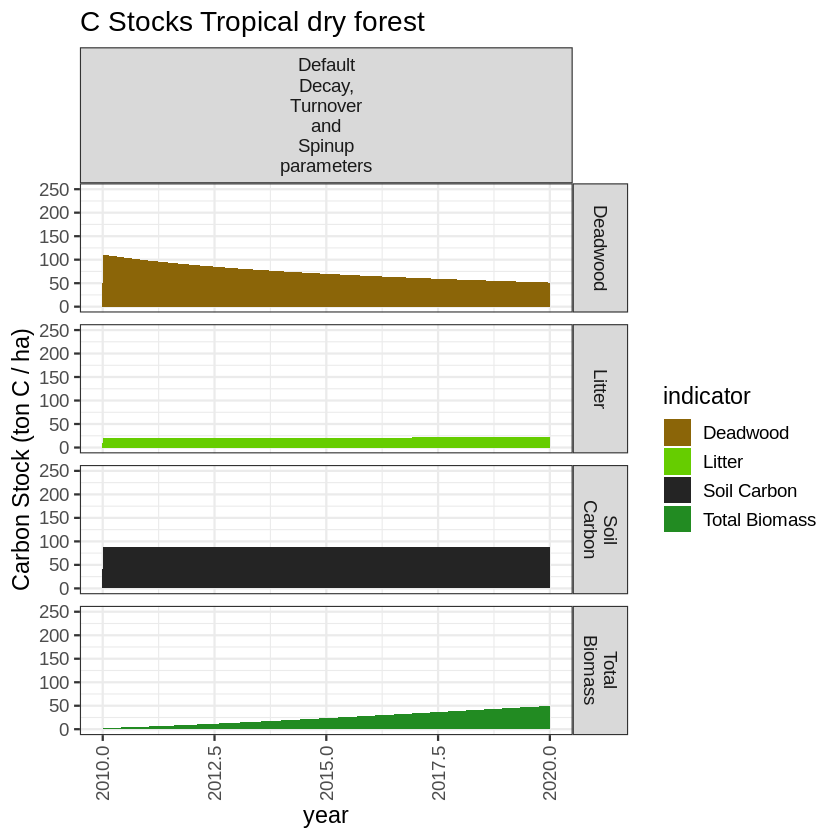

In [ ]:
plots[[3]]

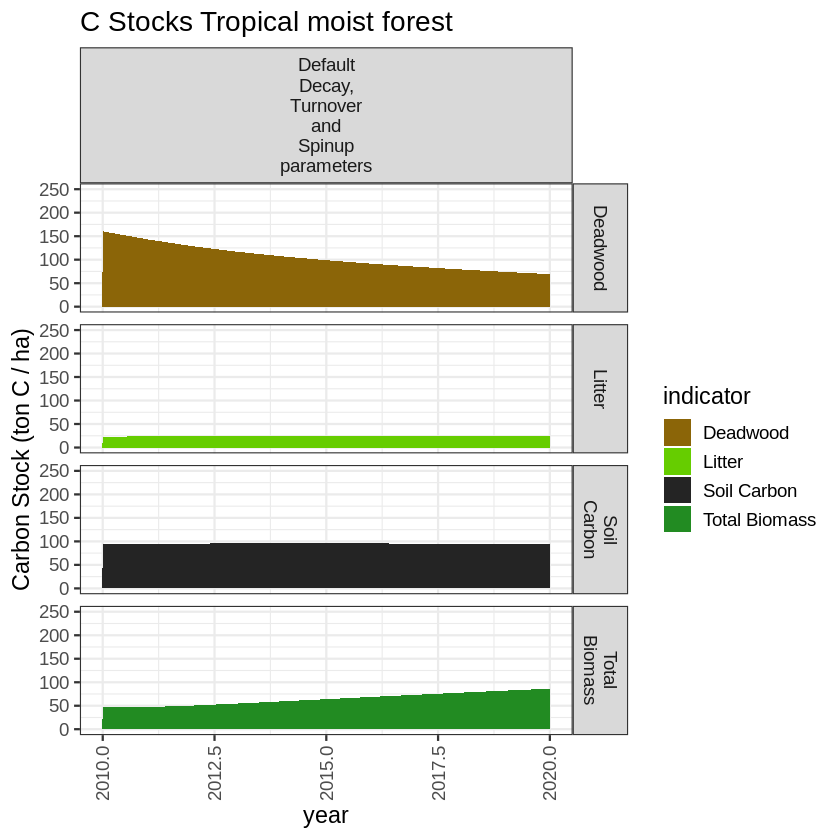

In [ ]:
plots[[4]]

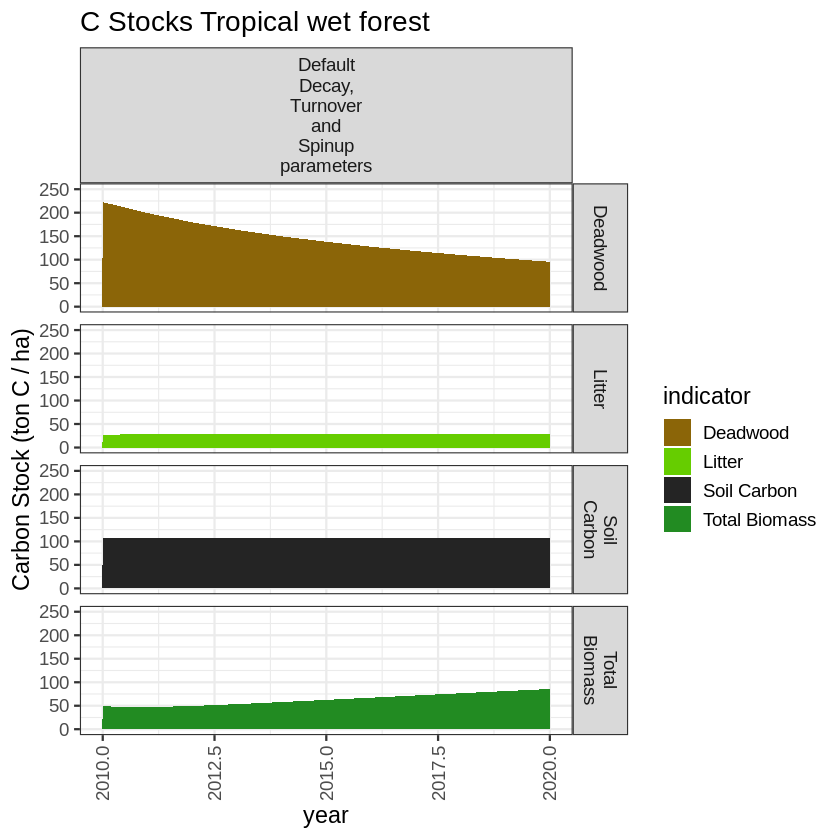

In [ ]:
plots[[5]]

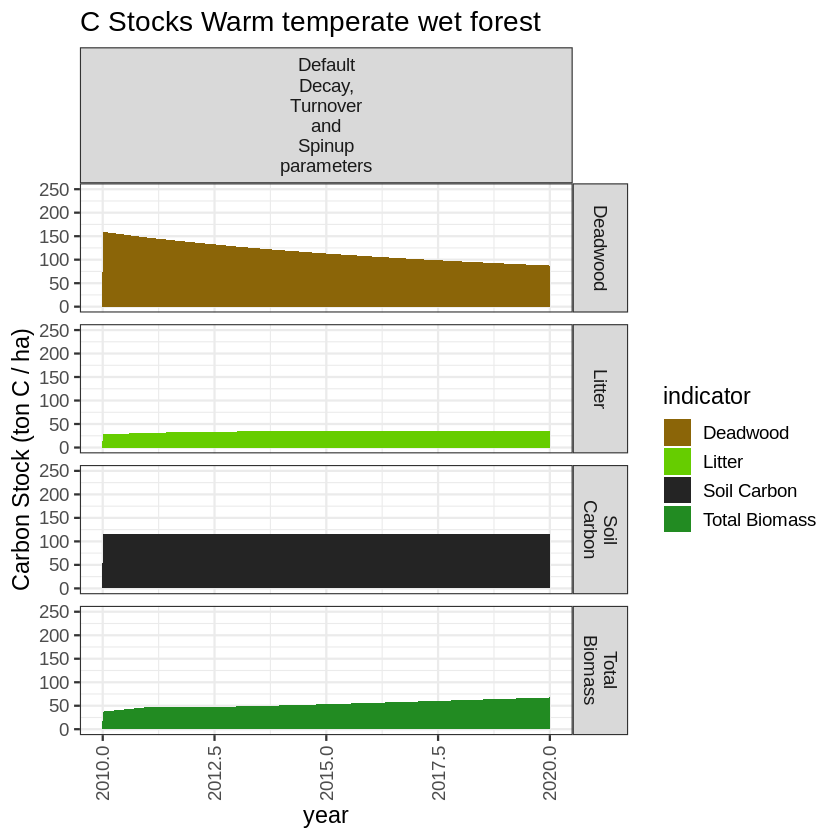

In [ ]:
plots[[6]]

### Code

In [ ]:
# ----------------------------
# Make Tables and Figures for the GCBM estimations on DOM pools
# ----------------------------

if(!require(tidyverse)){install.packages("tidyverse")}
if(!require(RSQLite)){install.packages("RSQLite")}
if(!require(writexl)){install.packages("writexl")}
library(tidyverse)
library(RSQLite)
library(writexl)

# Avoid scientific notation
options(scipen=10000)

In [ ]:
# List the directories of the different GCBM runs
# Here only one directory is listed, but mode than one can be made to make a sensitivity analysis
# e.g. runs <- c('../Standalone_GCBM','../Standalone_GCBM_decaymod','../Standalone_GCBM_turnovermod')
runs <- c('Standalone_GCBM')

In [ ]:
# Make a named vector to point the name you want each run to have in the graph
# Here only one name is listed, but mode than one can be made to make a sensitivity analysis
# e.g. names_runs <- c('Default','Modified Decay parameters',Modified Decay, Turnover and Spinup parameters')
names_runs <- c('Default Decay, Turnover and Spinup parameters')
names_runs <- c('Standalone_GCBM' = 'Default Decay, Turnover and Spinup parameters')

In [ ]:
#Loop though the runs
for (run in runs) {

  # Path to the database
  path_db<-paste0(run,"/processed_output/compiled_gcbm_output.db")
  #----------------------

  # Connect to the database
  conn <- dbConnect(RSQLite::SQLite(), path_db)

  # List the tables in the databases
  dbListTables(conn)

  # Pool indicators
  pool_ind<-dbGetQuery(conn, "SELECT * FROM v_pool_indicators")

  # Calculate the pools total carbon for forests per lifezone and year
  pools_run<-pool_ind %>% filter(indicator %in% c("Total Biomass","Deadwood","Litter","Soil Carbon")) %>%
    group_by(year,indicator,LifeZone) %>%
    summarize(pool_tc_sum=sum(pool_tc))


  # Get the areas for each lifezone
  age_ind<-dbGetQuery(conn, "SELECT * FROM v_age_indicators")
  areas_run<-age_ind %>%
    group_by(year,LifeZone) %>%
    summarize(area_sum=sum(area)) %>%
    ungroup()

  # Divide the DOM values per area to obtain ton/ha values
  pools_run_area <- left_join(pools_run,areas_run,by = c("year","LifeZone"))
  pools_run_area <- mutate(pools_run_area, pool_tc_per_ha = pool_tc_sum/area_sum)
  pools_run_area$run <- run

  # Recode the runs
  pools_run_area$run <- as.character(recode(pools_run_area$run, !!!names_runs))

  # Make a compiled database
  if(exists("pools_full")){
    pools_full <- unique(rbind(pools_full,pools_run_area))
  } else {
    pools_full <- pools_run_area
  }

  print(run)

  dbDisconnect(conn)


}

In [ ]:
# Check the recoding
unique(pools_full$run)

[1] "Default Decay, Turnover and Spinup parameters"

In [ ]:
#Write full table
write_csv(pools_full,"Tables/Pools_DOM_Sensitivity_full.csv")

In [ ]:
# Make a Table with the DOM stocks every 1 year, from 0 to 10 years old
pools_summary <- pools_full %>%
  filter(year %in% seq(2010, 2020, by=1)) %>%
  mutate(Age = year - 2010)

for (ag in unique(pools_summary$Age)) {

  # Make a pools table for that specific age (ag)
  pools_forest <- pools_summary %>%
    filter(Age == ag) %>%
    select(indicator, LifeZone, pool_tc_per_ha, run) %>%
    pivot_wider(names_from = run, values_from = pool_tc_per_ha)

  # Write a table every 1 year
  write_csv(pools_forest, paste0("Tables/Pools_DOM_Sensitivity_forest_", ag, "_years.csv"))
}

In [ ]:
# Function to create plot for each life zone with fixed y-axis limits
make_life_zone_plot <- function(data, life_zone, ymin, ymax) {
  p <- ggplot(filter(data, LifeZone == life_zone), aes(x = year, y = pool_tc_per_ha, fill = indicator)) +
    geom_area() +
    facet_grid(indicator ~ run, scales = "free_x", labeller = label_wrap_gen(width = 7)) +
    ylab("Carbon Stock (ton C / ha)") +
    scale_y_continuous(limits = c(ymin, ymax)) +  # Setting fixed y-axis limits
    scale_fill_manual(values = c("darkgoldenrod4", "chartreuse3", "gray14", "forestgreen")) +
    ggtitle(paste("C Stocks", life_zone)) +
    theme_bw(14) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

  return(p)
}

# Applying the function with fixed y-axis limits
ymin <- 0
ymax <- 250

# List of life zones
life_zones <- c("Subtropical moist forest", "Subtropical wet forest", "Tropical dry forest",
                "Tropical moist forest", "Tropical wet forest", "Warm temperate wet forest")

# Apply the function to each life zone with the specified y-axis limits
plots <- lapply(life_zones, function(zone) make_life_zone_plot(pools_full, zone, ymin, ymax))
